In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import re
from nltk import FreqDist


from wordcloud import WordCloud
import ast # used for converting column values to lists post-import from csv

from nltk import FreqDist
from nltk.corpus import stopwords

pd.set_option("display.max_columns", None)



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore') # supresses errors



In [49]:
# creating a list of the nltk's English-language stopwords
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [50]:
# a small function to quickly remove stopwords from the 'step_tokens' column 
def remove_stop_words(count, stop_words):
    for x in count.index:
        if x in stop_words:
            count = count.drop(x)
    
    return count

In [51]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5):
    '''
Function takes in estimator, training data, test data, 
and the cross validation splitting strategy, and returns the accuracy, precision, recall, f1 and the ROC-AUC
scores for the model as well as a confusion matrix visualization.  From Phase 3 Project: 
https://github.com/Nindorph/TanzanianWaterWells/blob/main/Modeling_Final.ipynb and Lindsey Berlin’s evaluate function
found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  
        Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a (Stratified)KFold,
        - CV splitter,
        - An iterable yielding (train, test) splits as arrays of indices


Returns – nothing is returned 


    '''

    output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                            scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
    #Printing out the mean of all of our evaluating metrics across the cross validation. 
    #Accuracy, precisionc recall, f1, and roc auc
    print('Results of Cross-Validation:\n')
    print(f'Average accuracy: {output["test_accuracy"].mean()}\
    +/- {output["test_accuracy"].std()}')
    print(f'Average precision: {output["test_precision"].mean()}\
    +/- {output["test_precision"].std()}')
    print(f'**Average recall: {output["test_recall"].mean()}\
    +/- {output["test_recall"].std()}')
    print(f'Average f1 score: {output["test_f1"].mean()}\
    +/- {output["test_f1"].std()}')
    print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
    +/- {output["test_roc_auc"].std()}\n')
    print('+'*20)


    #Fitting the estimator to our X and y train data
    estimator.fit(X_tr, y_tr)
    #getting predictions for X train
    tr_preds = estimator.predict(X_tr)
    #getting predictions for X test
    te_preds = estimator.predict(X_te)

    #Creating a confusion matrix from our data with custom labels
    print('\nResults of Train-Test Split Validation:')
    plot_confusion_matrix(estimator, X_te, y_te, cmap='mako')
    plt.show()

    #Printing our final evaluating metrics across X train
    #Evaluating using accuracy, precision, recall, f1, roc auc
    print("\nTraining Scores:")
    print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train precision: {precision_score(y_tr, tr_preds)}")
    print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
    print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
    print("<>"*10)
    #Printing our final evaluating metrics across X test
    #Evaluating using accuracy, precision, recall, f1, roc auc
    print("\nTesting Scores:")
    print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test precision: {precision_score(y_te, te_preds)}")
    print(f"**Test recall: {recall_score(y_te, te_preds)}")
    print(f"Test f1 score: {f1_score(y_te, te_preds)}")
    print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")


In [52]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_train = pd.read_csv('../data/y_train.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv', index_col=0)

In [53]:
print(f'Train {y_train.value_counts()}')
print(f'Test  {y_test.value_counts()}')
print(f'Holdout {y_holdout.value_counts()}')

Train target
0         68716
1         68577
dtype: int64
Test  target
1         20714
0         20474
dtype: int64
Holdout target
0         6284
1         6142
dtype: int64


In [54]:
rus = RandomUnderSampler(random_state=50)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)


target
1         68577
0         68577
dtype: int64

In [55]:
print(f'Train {y_train.value_counts()}')
print(f'Test  {y_test.value_counts()}')
print(f'Holdout {y_holdout.value_counts()}')

Train target
0         68716
1         68577
dtype: int64
Test  target
1         20714
0         20474
dtype: int64
Holdout target
0         6284
1         6142
dtype: int64


To prepare the data for vectorization the columns containing text will have to be combined into a single string that will be used in the model to meet the input requirements for the vectorizers.

In [117]:
# creating a new column compatible with vectorizer inputs 
X_train['combined'] = X_train['cleaned_description'].str.cat(X_train[['cleaned_steps',
                                                                      'cleaned_ingredients']],sep=" ")

X_train.head()

<ipython-input-117-597d61def186>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['combined'] = X_train['cleaned_description'].str.cat(X_train[['cleaned_steps',


,cleaned_description,cleaned_steps,cleaned_ingredients,combined
47827,i tried some recipes for making sweet sour sau...,add the oil sugar and vinegar to a small sauce...,sugar vinegar ketchup water pineapple juice co...,i tried some recipes for making sweet sour sau...
129467,this is the soup that moroccans traditionally ...,place the lamb turmeric black pepper cinnamon ...,lamb ground turmeric ground black pepper groun...,this is the soup that moroccans traditionally ...
184947,i really loved my friends lemon chicken pasta ...,cook chicken your favorite way i usually salt ...,chicken pasta avocados olive oil green onion f...,i really loved my friends lemon chicken pasta ...
98991,a nice change to the tradtional gratin \r \r w...,preheat the oven to cfan cgas put the cream ga...,double cream garlic cloves fresh thyme leave p...,a nice change to the tradtional gratin \r \r w...
159123,this has amazed our guests for years but is so...,in a large nonreactive pot with lid melt butte...,unsalted butter garlic cloves fresh ground bla...,this has amazed our guests for years but is so...


In [119]:
# repeating this with the test data
X_test['combined'] = X_test['cleaned_description'].str.cat(X_test[['cleaned_steps',
                                                                'cleaned_ingredients']],sep=" ")
X_test.head()

,cleaned_description,cleaned_steps,cleaned_ingredients,combined
97436,my favorite dinner party soup cooking the drie...,cover mushrooms with cold water and soak overn...,dried wild mushrooms beef stock butter onion c...,my favorite dinner party soup cooking the drie...
147954,this is from the wsu extension office i havent...,saute in pan on medium heat in oil zucchini mu...,zucchini sliced mushrooms onions flour tortill...,this is from the wsu extension office i havent...
10086,recipe by tyler florencethis is soooo good the...,first thing to do is to steam the artichokes i...,fresh parsley water garlic cloves bay leaves d...,recipe by tyler florencethis is soooo good the...
178888,im very picky about my chili as i get terrible...,note for a soupier chili use a oz bottle of v ...,v vegetable juice chili seasoning mix chili st...,im very picky about my chili as i get terrible...
136500,this is a very quick recipe so easy my husband...,thaw frozen tilapia soak in milk for hour disc...,tilapia fillet lowfat milk panko breadcrumbs m...,this is a very quick recipe so easy my husband...


## Modeling  

To begin the modeling process basic, nlp appropriate,  models are created and run with both types of vectorized datasets.  This will identify which models deserve more attention and fine tuning.

In [120]:
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


### CountVectorizer

In [121]:
# having the CountVectorizer remove stop words
countvect = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))

In [122]:
X_train_CV = countvect.fit_transform(X_train.combined)
X_test_CV = countvect.transform(X_test.combined)

In [123]:
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=3), #to keep the initial modeling quick
    "RandomForestClassifier": RandomForestClassifier(max_depth=3),
    "LogisticRegression": LogisticRegression(penalty = 'elasticnet',l1_ratio =.5, solver='saga'),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

BernoulliNB
Results of Cross-Validation:

Average accuracy: 0.6679437230396654        +/- 0.002355052279753311
Average precision: 0.6288082257136919        +/- 0.0020276220377248248
**Average recall: 0.8182334449353144        +/- 0.002507729848902346
Average f1 score: 0.7111205451612952        +/- 0.0019129888678486272
Average roc_auc: 0.7372718944460759        +/- 0.002784791836307464

++++++++++++++++++++

Results of Train-Test Split Validation:


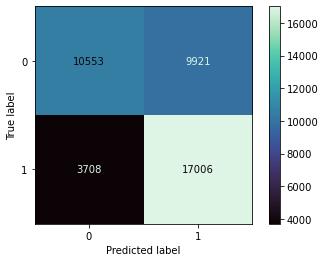


Training Scores:
Train accuracy: 0.6890300306643456
Train precision: 0.6456277358299481
**Train recall: 0.8366507721247649
Train f1 score: 0.7288305683290568
Train roc_auc: 0.6891793356519977

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6691026512576479
Test precision: 0.6315594013443755
**Test recall: 0.8209906343535773
Test f1 score: 0.7139228815516047
Test roc_auc: 0.6682124217972829
ComplementNB
Results of Cross-Validation:

Average accuracy: 0.6707115333681354        +/- 0.0029129439936998233
Average precision: 0.6324789939954696        +/- 0.002630152109688461
**Average recall: 0.8134505701673669        +/- 0.002158602833565433
Average f1 score: 0.7116373254647977        +/- 0.002197934438393689
Average roc_auc: 0.7262719748920242        +/- 0.0031016082520470938

++++++++++++++++++++

Results of Train-Test Split Validation:


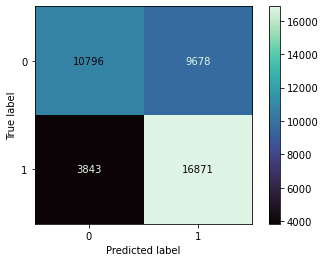


Training Scores:
Train accuracy: 0.6866118447408098
Train precision: 0.6452801437392679
**Train recall: 0.8274494363999592
Train f1 score: 0.7250980742936733
Train roc_auc: 0.6867542891878136

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6717247742060795
Test precision: 0.635466495913217
**Test recall: 0.8144733030800425
Test f1 score: 0.713919979688128
Test roc_auc: 0.670888111928807
MultinomialNB
Results of Cross-Validation:

Average accuracy: 0.6706678318495076        +/- 0.002958196156416409
Average precision: 0.6324599938550718        +/- 0.0026618226264351437
**Average recall: 0.8133339117031323        +/- 0.0021728521007704483
Average f1 score: 0.7115807129568601        +/- 0.0022387734212169336
Average roc_auc: 0.726271771725853        +/- 0.0031020696605689423

++++++++++++++++++++

Results of Train-Test Split Validation:


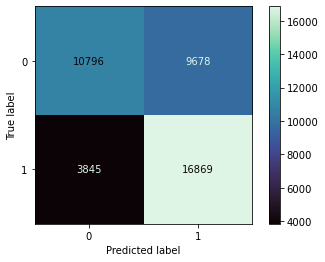


Training Scores:
Train accuracy: 0.6866118447408098
Train precision: 0.6452900569764929
**Train recall: 0.8274056899543579
Train f1 score: 0.725087535461446
Train roc_auc: 0.6867542449422526

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6716762163737011
Test precision: 0.6354390326590575
**Test recall: 0.8143767500241382
Test f1 score: 0.7138655551088635
Test roc_auc: 0.6708398354008549
DecisionTreeClassifier
Results of Cross-Validation:

Average accuracy: 0.6302506252702182        +/- 0.0022799506841740536
Average precision: 0.5937228203195488        +/- 0.001953660168237351
**Average recall: 0.8227976672134598        +/- 0.002589747690459817
Average f1 score: 0.6897339868719056        +/- 0.0015606707081552013
Average roc_auc: 0.6633773484533071        +/- 0.00293947412646339

++++++++++++++++++++

Results of Train-Test Split Validation:


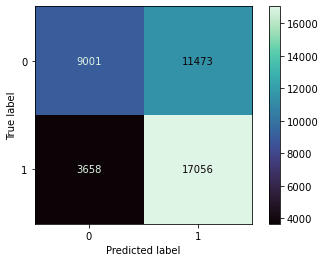


Training Scores:
Train accuracy: 0.6302287807827056
Train precision: 0.5935241976138464
**Train recall: 0.8240809600886595
Train f1 score: 0.6900539095077324
Train roc_auc: 0.6304248446755656

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6326357191414975
Test precision: 0.5978478039889236
**Test recall: 0.8234044607511828
Test f1 score: 0.6927279004122414
Test roc_auc: 0.6315176059739112
RandomForestClassifier
Results of Cross-Validation:

Average accuracy: 0.6552336845919686        +/- 0.004243029092889223
Average precision: 0.618659804839427        +/- 0.004344891354898234
**Average recall: 0.8078075351165623        +/- 0.01070761748648875
Average f1 score: 0.7006428754182938        +/- 0.0039656137311953705
Average roc_auc: 0.7157695130564956        +/- 0.004305378109224001

++++++++++++++++++++

Results of Train-Test Split Validation:


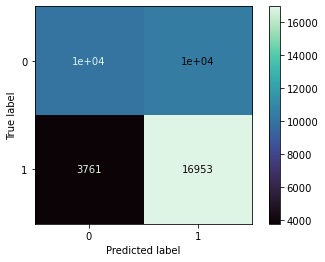


Training Scores:
Train accuracy: 0.6584093872229465
Train precision: 0.6193554070273187
**Train recall: 0.8202166907272117
Train f1 score: 0.7057731156756214
Train roc_auc: 0.6585730406310836

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6557978051859765
Test precision: 0.6194234352734846
**Test recall: 0.8184319783721155
Test f1 score: 0.7051556683235238
Test roc_auc: 0.6548445913155878
LogisticRegression


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

Results of Cross-Validation:

Average accuracy: 0.7047919473296484        +/- 0.002985944526235162
Average precision: 0.6937834325764138        +/- 0.0038622508896213165
**Average recall: 0.7321842996627488        +/- 0.002389190477041988
Average f1 score: 0.7124592333492616        +/- 0.0023000278531779043
Average roc_auc: 0.7734116543390103        +/- 0.002221917266614091

++++++++++++++++++++


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



Results of Train-Test Split Validation:


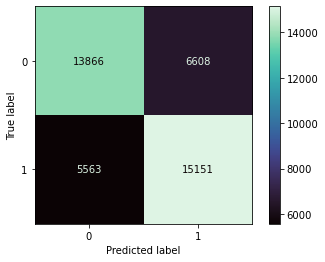


Training Scores:
Train accuracy: 0.7360171312448559
Train precision: 0.7227289008899788
**Train recall: 0.7649795120813101
Train f1 score: 0.7432542521765618
Train roc_auc: 0.7360464240655693

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7045013110614742
Test precision: 0.6963095730502321
**Test recall: 0.7314376750024139
Test f1 score: 0.7134414804699456
Test roc_auc: 0.7043434345511239
AdaBoostClassifier
Results of Cross-Validation:

Average accuracy: 0.6770264861023729        +/- 0.0016943112551757664
Average precision: 0.661160057975897        +/- 0.0022787948166429362
**Average recall: 0.724951552492322        +/- 0.0034026466143041315
Average f1 score: 0.6915796698058235        +/- 0.0015065836250136842
Average roc_auc: 0.7461105398796818        +/- 0.0016015419234329733

++++++++++++++++++++

Results of Train-Test Split Validation:


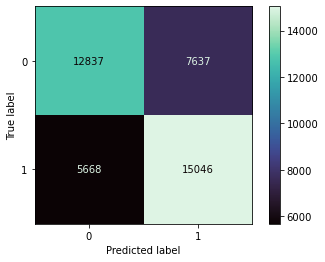


Training Scores:
Train accuracy: 0.6773542715214905
Train precision: 0.6611233509409922
**Train recall: 0.7263805649124342
Train f1 score: 0.6922173662305539
Train roc_auc: 0.6774038571695299

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6769690201029426
Test precision: 0.6633161398404092
**Test recall: 0.7263686395674424
Test f1 score: 0.69341198700371
Test roc_auc: 0.6766794843827248


In [124]:
for name, sklearn_classifier in classifiers.items():
    classifier = sklearn_classifier
    print(name)
    evaluate(classifier, X_train_CV, X_test_CV, y_train, y_test)

### TfidfVectorizer

In [125]:
tfidf = TfidfVectorizer(stop_words = stop_words)
X_train_tfidf = tfidf.fit_transform(X_train.combined)
X_test_tfidf = tfidf.transform(X_test.combined)

In [129]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [126]:
# removing KNeighborsClassifier from the list of options as it takes too long to run
# with mediocre results when used with the CountVectorizer

classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=3), #to keep the initial modeling quick
    "RandomForestClassifier": RandomForestClassifier(max_depth=3),
    "LogisticRegression": LogisticRegression(penalty = 'elasticnet',l1_ratio =.5, solver='saga'),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

BernoulliNB
Results of Cross-Validation:

Average accuracy: 0.6679437230396654        +/- 0.002355052279753311
Average precision: 0.6288082257136919        +/- 0.0020276220377248248
**Average recall: 0.8182334449353144        +/- 0.002507729848902346
Average f1 score: 0.7111205451612952        +/- 0.0019129888678486272
Average roc_auc: 0.7372718944460759        +/- 0.002784791836307464

++++++++++++++++++++

Results of Train-Test Split Validation:


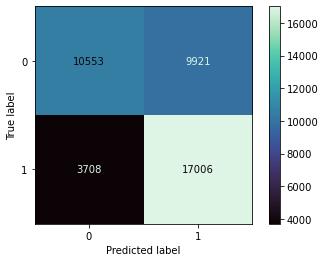


Training Scores:
Train accuracy: 0.6890300306643456
Train precision: 0.6456277358299481
**Train recall: 0.8366507721247649
Train f1 score: 0.7288305683290568
Train roc_auc: 0.6891793356519977

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6691026512576479
Test precision: 0.6315594013443755
**Test recall: 0.8209906343535773
Test f1 score: 0.7139228815516047
Test roc_auc: 0.6682124217972829
ComplementNB
Results of Cross-Validation:

Average accuracy: 0.6767569923431171        +/- 0.002685799123032517
Average precision: 0.6413717247113541        +/- 0.0026018594467296205
**Average recall: 0.8004578828241925        +/- 0.0018746067605576115
Average f1 score: 0.7121355622030373        +/- 0.001978348558231771
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026

++++++++++++++++++++

Results of Train-Test Split Validation:


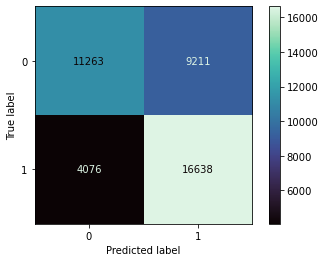


Training Scores:
Train accuracy: 0.6971367804622232
Train precision: 0.658093230264699
**Train recall: 0.8193417618151858
Train f1 score: 0.7299180940132634
Train roc_auc: 0.6972603797142756

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6774060405943478
Test precision: 0.6436612634918178
**Test recall: 0.803224872067201
Test f1 score: 0.7146446749565105
Test roc_auc: 0.6766686048330534
MultinomialNB
Results of Cross-Validation:

Average accuracy: 0.6767569931389056        +/- 0.0026251702785135564
Average precision: 0.6414577304862454        +/- 0.0025648688226974745
**Average recall: 0.8000787507892781        +/- 0.0018291914138574743
Average f1 score: 0.7120383996765376        +/- 0.0019157732080198335
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026

++++++++++++++++++++

Results of Train-Test Split Validation:


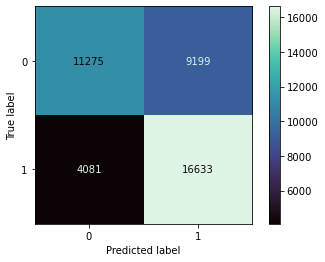


Training Scores:
Train accuracy: 0.697238752157794
Train precision: 0.6582716107256703
**Train recall: 0.8190647009930443
Train f1 score: 0.729917806439037
Train roc_auc: 0.6973619680528409

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6775759930076721
Test precision: 0.6438912976153608
**Test recall: 0.8029834894274404
Test f1 score: 0.7146908434666781
Test roc_auc: 0.6768409681190147
DecisionTreeClassifier
Results of Cross-Validation:

Average accuracy: 0.6305128365040875        +/- 0.0020716757364631884
Average precision: 0.5942676548309842        +/- 0.0018375529576019885
**Average recall: 0.8204499451239758        +/- 0.003048503280868797
Average f1 score: 0.6892732858430838        +/- 0.0014567472373081848
Average roc_auc: 0.663055875539024        +/- 0.0024670581470042884

++++++++++++++++++++

Results of Train-Test Split Validation:


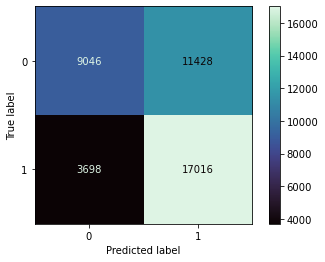


Training Scores:
Train accuracy: 0.6307167881829372
Train precision: 0.5942074809498213
**Train recall: 0.822126952185135
Train f1 score: 0.6898285798186691
Train roc_auc: 0.6309103821988601

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6327571137224435
Test precision: 0.5982280973140205
**Test recall: 0.8214733996330984
Test f1 score: 0.6922983034297571
Test roc_auc: 0.6316510301867748
RandomForestClassifier
Results of Cross-Validation:

Average accuracy: 0.6553720212733034        +/- 0.006234625201656038
Average precision: 0.6233273717282259        +/- 0.005050379524424526
**Average recall: 0.7835860756195121        +/- 0.00969601189805187
Average f1 score: 0.6943075387192814        +/- 0.0059674958186840665
Average roc_auc: 0.7161064596256986        +/- 0.004941657596469747

++++++++++++++++++++

Results of Train-Test Split Validation:


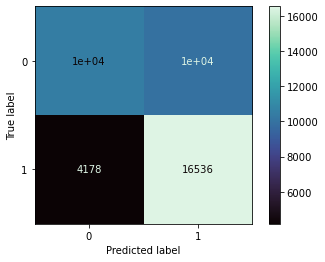


Training Scores:
Train accuracy: 0.6574406561150241
Train precision: 0.6224399336258041
**Train recall: 0.798605946600172
Train f1 score: 0.6996033545601451
Train roc_auc: 0.6575834319996611

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6556278527726522
Test precision: 0.6230125838294025
**Test recall: 0.7983006662160858
Test f1 score: 0.6998476383951244
Test roc_auc: 0.6547916342704927
LogisticRegression
Results of Cross-Validation:

Average accuracy: 0.7102109937320492        +/- 0.0013818965212887846
Average precision: 0.699253318003423        +/- 0.0016925889402733649
**Average recall: 0.7366901576238443        +/- 0.0026499199864471216
Average f1 score: 0.7174799331804131        +/- 0.0014341735471591994
Average roc_auc: 0.7845830512199936        +/- 0.0016728732962070642

++++++++++++++++++++

Results of Train-Test Split Validation:


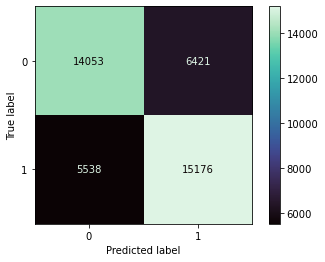


Training Scores:
Train accuracy: 0.7319382634220244
Train precision: 0.719864928450829
**Train recall: 0.7585050381323184
Train f1 score: 0.738680015621117
Train roc_auc: 0.7319651333044735

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7096484412935806
Test precision: 0.7026901884520999
**Test recall: 0.7326445882012166
Test f1 score: 0.7173548249864102
Test roc_auc: 0.7095136587582229
AdaBoostClassifier
Results of Cross-Validation:

Average accuracy: 0.678410389011874        +/- 0.0019428737357940935
Average precision: 0.6644931152129286        +/- 0.002818424532377354
**Average recall: 0.7194833158918691        +/- 0.006592810246041841
Average f1 score: 0.6908708797403835        +/- 0.002527923487022844
Average roc_auc: 0.7486999508644392        +/- 0.0020978925804910654

++++++++++++++++++++

Results of Train-Test Split Validation:


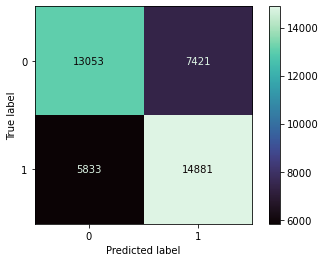


Training Scores:
Train accuracy: 0.6810689547172835
Train precision: 0.6672558967992659
**Train recall: 0.7210726628461438
Train f1 score: 0.6931212110593266
Train roc_auc: 0.6811094148388702

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6782072448285908
Test precision: 0.667249574029235
**Test recall: 0.7184030124553442
Test f1 score: 0.691882090384973
Test roc_auc: 0.6779716537318238


In [127]:
for name, sklearn_classifier in classifiers.items():
    classifier = sklearn_classifier
    print(name)
    evaluate(classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)

An interesting result of running the basic models with both CountVectorized and TdifdVectorized data is seeing how both types produce near identical results with this data set, meaning that we could proceed with using either on the "scores" front.  That being said the data transformed with TdifdVectorizer did not trigger a convergence warning while being run through the LogisticRegression model, our best performing one, so we will proceed with using that dataset as the default. A possible next step would be to use both vectorizers on the dataset to see if that improves performance.

## Delete This

adaboost  
Average accuracy: 0.678410389011874        +/- 0.0019428737357940935  
Average precision: 0.6644931152129286        +/- 0.002818424532377354  
Average recall: 0.7194833158918691        +/- 0.006592810246041841  
Average f1 score: 0.6908708797403835        +/- 0.002527923487022844  
Average roc_auc: 0.7486999508644392     

LogisticRegression  
Results of Cross-Validation:

Average accuracy: 0.7102109937320492        +/- 0.0013818965212887846  
Average precision: 0.699253318003423        +/- 0.0016925889402733649  
Average recall: 0.7366901576238443        +/- 0.0026499199864471216  
Average f1 score: 0.7174799331804131        +/- 0.0014341735471591994  
Average roc_auc: 0.7845830512199936        +/- 0.0016728732962070642  
  
DecisionTreeClassifier  
Results of Cross-Validation:  

Average accuracy: 0.6305128365040875        +/- 0.0020716757364631884  
Average precision: 0.5942676548309842        +/- 0.0018375529576019885  
Average recall: 0.8204499451239758        +/- 0.003048503280868797  
Average f1 score: 0.6892732858430838        +/- 0.0014567472373081848  
Average roc_auc: 0.663055875539024        +/- 0.0024670581470042884  

MultinomialNB  
Results of Cross-Validation:  

Average accuracy: 0.6767569931389056        +/- 0.0026251702785135564  
Average precision: 0.6414577304862454        +/- 0.0025648688226974745  
Average recall: 0.8000787507892781        +/- 0.0018291914138574743  
Average f1 score: 0.7120383996765376        +/- 0.0019157732080198335  
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026  

ComplementNB  
Results of Cross-Validation:  

Average accuracy: 0.6767569923431171        +/- 0.002685799123032517  
Average precision: 0.6413717247113541        +/- 0.0026018594467296205  
Average recall: 0.8004578828241925        +/- 0.0018746067605576115  
Average f1 score: 0.7121355622030373        +/- 0.001978348558231771  
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026    

BernoulliNB  
Results of Cross-Validation:  

Average accuracy: 0.6679437230396654        +/- 0.002355052279753311  
Average precision: 0.6288082257136919        +/- 0.0020276220377248248  
**Average recall: 0.8182334449353144        +/- 0.002507729848902346  
Average f1 score: 0.7111205451612952        +/- 0.0019129888678486272  
Average roc_auc: 0.7372718944460759        +/- 0.002784791836307464  



The evaluation results for each model show Logistic Regression, MultinomialNB, and ComplementNB having the best performance with the current dataset.  Interestingly the Naieve Bayes' models had near identical outputs and so moving forward we'll only work with ComplementNB as that's best suited for inbalanced datasets, which is not an issue.  Per the documentation MultinomialNB nominally requires integer feature counts even though it will word with the TdifdVectorizer's fractional outputs. Despite this we'll continue to use the Tdifd dataset as MultinomialNB performed slightly better using it. 

Although it didn't fare particularly well when compared with the other models the DecisionTree will also undergo some hyperparameter tuning as the initial model was in part designed to be processed quickly so simply increasing the max_depth outputs may provide better results.

## Hyperparameter Tuning

In [131]:
from sklearn.pipeline import Pipeline

### MultinomialNB  

The MultinomialNB model takes in only 3 parameters: alpha, fit_prior, and class_prior, making it an excellent starting point for hyperparameter tuning. 

In [132]:
#creating a pipeline including the TfidfVectorizer as well as the model

mnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [142]:
mnb_params = {
    'tfidf__max_df': [.5, .95, 1],
    'tfidf__min_df': [.05, .1, 1],
    'mnb__fit_prior': [True, False]
}



In [143]:
mnb_clf = GridSearchCV(mnb_pipe, mnb_params)
mnb_clf.fit(X_train.combined, y_train)

mnb_results = pd.DataFrame(mnb_clf.cv_results_)
mnb_results

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__fit_prior,param_tfidf__max_df,param_tfidf__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.965661,0.065794,2.501618,0.025552,True,0.5,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.650097,0.652282,0.657380,0.650266,0.652779,0.652561,0.002634,8
1,9.916038,0.061899,2.446347,0.011761,True,0.5,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.643286,0.646127,0.646600,0.642691,0.644111,0.644563,0.001545,12
2,10.203095,0.052868,2.619587,0.023444,True,0.5,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.673586,0.676645,0.681052,0.674339,0.676998,0.676524,0.002613,3
3,9.906418,0.055593,2.448342,0.023860,True,0.95,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.650861,0.652937,0.658291,0.651395,0.653544,0.653405,0.002631,6
4,9.906428,0.036256,2.419746,0.013514,True,0.95,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.644743,0.646600,0.648858,0.644147,0.646624,0.646195,0.001658,10
5,10.256241,0.070232,2.560577,0.033690,True,0.95,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.673586,0.677009,0.681707,0.674922,0.677143,0.676874,0.002759,2
6,9.647015,0.059509,0.000000,0.000000,True,1,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 1, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
7,9.674976,0.048318,0.000000,0.000000,True,1,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 1, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
8,9.818348,0.084822,2.431551,0.016398,True,1,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 1, '...",0.500892,0.504352,0.501876,0.502768,0.502914,0.502560,0.001151,14
9,9.850005,0.017454,2.483353,0.010597,False,0.5,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.650424,0.652318,0.657708,0.650266,0.652706,0.652684,0.002695,7


In [146]:
mnb_results.sort_values(['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__fit_prior,param_tfidf__max_df,param_tfidf__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,10.253904,0.031836,2.565783,0.022885,False,0.95,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.673550,0.677046,0.681707,0.674849,0.677289,0.676888,0.002783,1
5,10.256241,0.070232,2.560577,0.033690,True,0.95,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.673586,0.677009,0.681707,0.674922,0.677143,0.676874,0.002759,2
2,10.203095,0.052868,2.619587,0.023444,True,0.5,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.673586,0.676645,0.681052,0.674339,0.676998,0.676524,0.002613,3
11,10.183689,0.022359,2.619974,0.023976,False,0.5,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.673440,0.676463,0.681161,0.674266,0.676888,0.676444,0.002691,4
12,9.875622,0.029626,2.445957,0.028096,False,0.95,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.650898,0.653228,0.658181,0.651249,0.653507,0.653413,0.002600,5
3,9.906418,0.055593,2.448342,0.023860,True,0.95,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.650861,0.652937,0.658291,0.651395,0.653544,0.653405,0.002631,6
9,9.850005,0.017454,2.483353,0.010597,False,0.5,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.650424,0.652318,0.657708,0.650266,0.652706,0.652684,0.002695,7
0,9.965661,0.065794,2.501618,0.025552,True,0.5,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.650097,0.652282,0.657380,0.650266,0.652779,0.652561,0.002634,8
13,9.851966,0.052688,2.398511,0.009189,False,0.95,0.1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.644561,0.646928,0.648858,0.644111,0.646842,0.646260,0.001734,9
4,9.906428,0.036256,2.419746,0.013514,True,0.95,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.644743,0.646600,0.648858,0.644147,0.646624,0.646195,0.001658,10


Looking at the top performing model the common hyperparameter was a max_df of .95 in the vectorization stage - this is a parameter that causes any word appearing more then a certain amount or percentage of times in the dataset to be dropped. This parameter was paired with a min_df, the smallest number or percentage of times a word can appear before being dropped, in the best performing values but since this is the default value of the hyperparameter it can be excluded from future GridSearches.

In [148]:
mnb_params2 = {
    'tfidf__max_df': [.9, .95, .98],
    'mnb__alpha' : [.5,1,1.5]
}

In [149]:
mnb_clf2 = GridSearchCV(mnb_pipe, mnb_params)
mnb_clf2.fit(X_train.combined, y_train)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__fit_prior,param_tfidf__max_df,param_tfidf__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,10.253904,0.031836,2.565783,0.022885,False,0.95,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.673550,0.677046,0.681707,0.674849,0.677289,0.676888,0.002783,1
5,10.256241,0.070232,2.560577,0.033690,True,0.95,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.673586,0.677009,0.681707,0.674922,0.677143,0.676874,0.002759,2
2,10.203095,0.052868,2.619587,0.023444,True,0.5,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.673586,0.676645,0.681052,0.674339,0.676998,0.676524,0.002613,3
11,10.183689,0.022359,2.619974,0.023976,False,0.5,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.673440,0.676463,0.681161,0.674266,0.676888,0.676444,0.002691,4
12,9.875622,0.029626,2.445957,0.028096,False,0.95,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.650898,0.653228,0.658181,0.651249,0.653507,0.653413,0.002600,5
3,9.906418,0.055593,2.448342,0.023860,True,0.95,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.650861,0.652937,0.658291,0.651395,0.653544,0.653405,0.002631,6
9,9.850005,0.017454,2.483353,0.010597,False,0.5,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.650424,0.652318,0.657708,0.650266,0.652706,0.652684,0.002695,7
0,9.965661,0.065794,2.501618,0.025552,True,0.5,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.650097,0.652282,0.657380,0.650266,0.652779,0.652561,0.002634,8
13,9.851966,0.052688,2.398511,0.009189,False,0.95,0.1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.644561,0.646928,0.648858,0.644111,0.646842,0.646260,0.001734,9
4,9.906428,0.036256,2.419746,0.013514,True,0.95,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.644743,0.646600,0.648858,0.644147,0.646624,0.646195,0.001658,10


In [158]:

mnb_results2 = pd.DataFrame(mnb_clf2.cv_results_)
mnb_results2.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,10.316146,0.048092,2.526971,0.022991,0.5,0.95,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.95}",0.673877,0.676973,0.681562,0.675249,0.677435,0.677019,0.002600,1
7,10.460898,0.032183,2.560774,0.013574,1.5,0.95,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.95}",0.673622,0.677446,0.681707,0.674812,0.677362,0.676990,0.002781,2
2,10.413343,0.058487,2.525544,0.008160,0.5,0.98,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.98}",0.673768,0.676973,0.681416,0.675213,0.677398,0.676954,0.002580,3
6,10.506733,0.092789,2.585181,0.029722,1.5,0.9,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.9}",0.673659,0.677301,0.681598,0.674922,0.677289,0.676954,0.002712,4
8,10.522913,0.120021,2.577702,0.082491,1.5,0.98,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.98}",0.673550,0.677446,0.681744,0.674740,0.677289,0.676954,0.002821,5


In order to facilitate evaluation a dataframe of scores is created to track GridSearchCV results.

In [180]:
def score_tracker( gscv_results, model_name, score_df=None):
    '''Takes in  GridSearchCV results  from 'cv_results_' attribute in dataframe form and cleans it up so it can be 
    appended to other results output, labeling each row with the other required attribute, 'model_name'. Has a score
    tracking dataframe as an optional argument - if passed the search results will be appended to the tracker. '''
    
    gscv_results['model'] = model_name
    results = gscv_results[['mean_fit_time','params','mean_test_score','std_test_score','model']]
    
    if score_df is not None:
        all_scores = pd.concat([score_df, results]).copy()
        return all_scores.sort_values('mean_test_score')
    else:
        return results

In [224]:
mnb2 = score_tracker(mnb_results2, 'mnb2')
all_scores = score_tracker(mnb_results, 'mnb', mnb2)


In [225]:
all_scores.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,params,mean_test_score,std_test_score,model
1,10.316146,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.95}",0.677019,0.002600,mnb2
7,10.460898,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.95}",0.676990,0.002781,mnb2
2,10.413343,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.98}",0.676954,0.002580,mnb2
6,10.506733,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.9}",0.676954,0.002712,mnb2
8,10.522913,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.98}",0.676954,0.002821,mnb2


### Logistic Regression

In [187]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In their article about hyperparameter tuning Machine Learning Mastery notes that "Logistic regression does not really have any critical hyperparameters to tune." and only calls out the 'solver', 'penalty', and 'C', parameters as having the potential to significantly affect the model's performance. Not having found additional sources to contradict the LogisticRegression GridSearch will only focus on these three. Special care needs to be taken as not all solvers work with all the penalties, however additional GridSearches will not need to be performed as the sklearn documentation for LogisticRegresssion states that the l1 penalty only works with the 'libliner' and 'saga' solvers, and the former is best suited for small datasets. While this is not true for the 'saga' solver if it proves to be the best an additional model will be run using 'l1' with 'saga'.

In [ ]:
lr_params = mnb_params = {
    'tfidf__max_df': [.95],
    'lr__penalty': ['none','l2'],
    'lr__solver': ['saga','sag','newton_cg'],
    'lr__C': [100, 1, .001],
    'lr__max_iter': [500, 1000]

}

In [226]:
lr_results = pd.DataFrame(lr_clf.cv_results_)
all_scores = score_tracker(lr_results, 'lr', all_scores)
all_scores.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,params,mean_test_score,std_test_score,model
15,14.304038,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711340,0.001640,lr
21,14.094365,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711333,0.001639,lr
22,13.816110,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
16,13.641670,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
9,74.288500,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678549,0.002303,lr
10,44.329188,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002295,lr
4,44.363741,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002304,lr
3,74.956035,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678542,0.002312,lr
1,10.316146,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.95}",0.677019,0.002600,mnb2
7,10.460898,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.95}",0.676990,0.002781,mnb2


In [204]:
#display full contents of columns so can see all params
pd.set_option('display.max_colwidth', -1)

<ipython-input-204-0c622cbabd62>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [219]:
# since of the top models used the saga sovler I am using those parameters with the 'elasticnet' and 'l1' values
lr2_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# no need to include the C parameter in the dictionary as the best models had C =1, the default value for the model
lr2_params = {
    'tfidf__max_df': [.95],
    'lr__penalty': ['elasticnet','l1'],
    'lr__solver': ['saga'],
    'lr__max_iter': [500, 1000]
}

lr2_clf = GridSearchCV(lr2_pipe, lr2_params)
lr2_clf.fit(X_train.combined, y_train)

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\mod

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__max_iter': [500, 1000],
                         'lr__penalty': ['elasticnet', 'l1'],
                         'lr__solver': ['saga'], 'tfidf__max_df': [0.95]})

In [228]:
lr2_results = pd.DataFrame(lr2_clf.cv_results_)
all_scores = score_tracker(lr2_results, 'lr2', all_scores)
all_scores.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,params,mean_test_score,std_test_score,model
15,14.304038,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711340,0.001640,lr
21,14.094365,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711333,0.001639,lr
22,13.816110,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
16,13.641670,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
1,51.611550,"{'lr__max_iter': 500, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711049,0.001705,lr2
3,46.998577,"{'lr__max_iter': 1000, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711041,0.001702,lr2
9,74.288500,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678549,0.002303,lr
10,44.329188,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002295,lr
4,44.363741,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002304,lr
3,74.956035,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678542,0.002312,lr


The additional solvers and penalties failed to improve the model's performance 

In [229]:
lr3_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# no need to include the C parameter in the dictionary as the best models had C =1, the default value for the model
lr3_params = {
    'tfidf__max_df': [.95],
    'lr__penalty': ['elasticnet'],
    'lr__solver': ['saga'],
    'lr__l1_ratio': [.25,.5,.75] 
}

lr3_clf = GridSearchCV(lr3_pipe, lr3_params)
lr3_clf.fit(X_train.combined, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__l1_ratio': [0.25, 0.5, 0.75],
                         'lr__penalty': ['elasticnet'], 'lr__solver': ['saga'],
                         'tfidf__max_df': [0.95]})

In [230]:
lr3_results = pd.DataFrame(lr3_clf.cv_results_)
all_scores = score_tracker(lr3_results, 'lr3', all_scores)
all_scores.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,params,mean_test_score,std_test_score,model
0,87.877606,"{'lr__l1_ratio': 0.25, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711347,0.001615,lr3
15,14.304038,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711340,0.001640,lr
21,14.094365,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711333,0.001639,lr
22,13.816110,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
16,13.641670,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
1,47.261942,"{'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711223,0.001850,lr3
1,51.611550,"{'lr__max_iter': 500, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711049,0.001705,lr2
3,46.998577,"{'lr__max_iter': 1000, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711041,0.001702,lr2
2,44.680443,"{'lr__l1_ratio': 0.75, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711034,0.001950,lr3
9,74.288500,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678549,0.002303,lr


In [231]:
all_scores.to_csv('data/all_scores2.csv')